# Causal ML

You will generate a synthetic dataset that purposefully contains confounders and see how failing to control for them biases the causal discovery.
Then, you will apply propensity analysis and meta-learners to compute a better estimate.

## Construct the dataset

Consider the case where a medicine is given to treat a certain disease.
Consider also, for the purpose of the exercise, that the true effect of the treatment is known (in reality it wouldn't be).
The choice of treatment (by the doctor and individuals' choice of getting treated) is influenced by age, income and education level. These are the confonders.

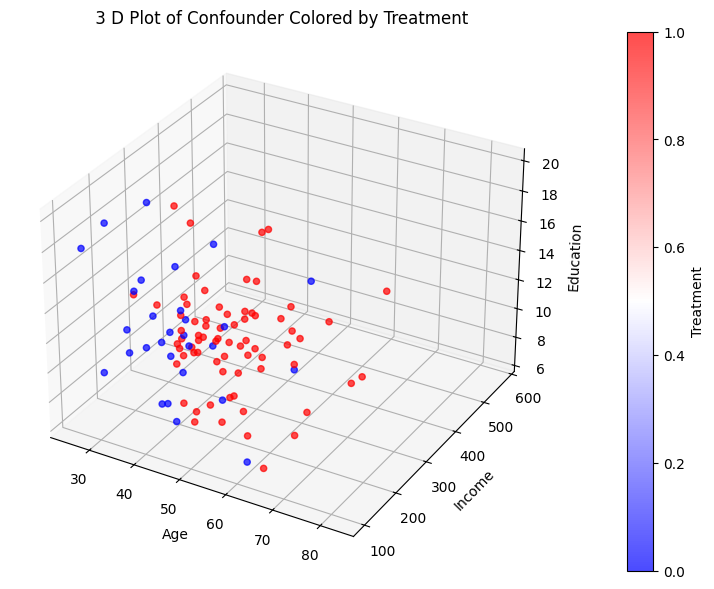

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as stats

# number of samples
n = 100

# Generate patients age, as Gaussian distribution with mean 50 and standard deviation 10
age = np.random.normal(loc=50, scale=10, size=n)
# Generate patients income, as Pareto distribution with shape parameter (alpha) 2.5,
# and scale parameter 100. Truncate the values such that the max is 10000.
income_raw = (np.random.pareto(a=2.5, size=n) + 1) * 100
income = np.minimum(income_raw, 100000)
# Generate education level, as Gaussian distribution with mean 13 (years) and standard
# deviation 3
education = np.random.normal(loc=13, scale=3, size=n)

# In our scenario, older, higher income and education subjects are more likely to get the
# treatement. We'll simulate this relationship. First, we model the likelihood of
# receiving treatement via a logistic function (which will output probabilities
# between 0 and 1). This likelihood will also be the propensity score.
propensity = 1 / (1 + np.exp(-(age - 45)/5 - (income - 10000)/80000 - (education - 13)/4))

# Treatement assignment is done by using the likelihood
treatment = np.random.binomial(1, propensity, n)

# We now turn to modeling the outcome.
# Suppose the real effect size is 3 (whatever that means - we don't care about the
# unit of measurement of the outcome for this excercise)
true_effect = 3
# Generate the outcome
# Add some Gaussian noise with mean 0 and standard deviation 5
noise = np.random.normal(loc=0, scale=5, size=n)
# Create the outcome as a liniar function of age, income, eductation, the treatment
# effect and noise
outcome = 3*age + 0.001*income + 2*education + true_effect*treatment + noise

# Create a dataframe of our data
data = pd.DataFrame({
    'age': age,
    'income': income,
    'education': education,
    'propensity': propensity,
    'treatment': treatment,
    'outcome': outcome
})

# Plot the dataset (age, income, education), while also showing (with different
# colors) the treatment status. Check whether indeed treatment depends on the
# confounders.

from mpl_toolkits.mplot3d import Axes3D

flg = plt.figure(figsize=(10, 7))
ax = flg.add_subplot(111, projection='3d')

sc=ax.scatter(data['age'], data['income'], data['education'], c=data['treatment'], cmap='bwr', alpha=0.7)
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Education')

plt.title(' 3 D Plot of Confounder Colored by Treatment')
plt.colorbar(sc, ax=ax, pad=0.1,  label='Treatment')
plt.show()

## Biased causal estimation
If we do causal detection without taking care of the confounders, we'll get a biased result, different from the true treatment effect.
We'll estimate causality using ATE, namely $E[Y|T=1] - E[Y|T=0]$

In [ ]:
# Compute ATE
biased_ATE = data[data['treatment'] == 1]['outcome'].mean() - data[data['treatment'] == 0]['outcome'].mean()
print("Estimated treatment effect with no control: ", biased_ATE)

Estimated treatment effect with no control:  43.20677869959431


## Propensity analysis

Since the data was already collected (generated) we cannot do a randomized trial.
Instead, we'll use propensity analysis to simulate randomness.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Propensity scores define the probability of the subjects to receive the treatment
# We'll use Random Forest to predict this probabilty based on age, income and education
X = data[['age', 'income', 'education']]
y = data['treatment']

# Train
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Predict
propensity_scores = clf.predict_proba(X)[:, 1]

# Add the propensity scores to the dataframe, so we can later group by scores
augmented_data = data
augmented_data['estimated_propensity'] = propensity_scores

# Group the estimated propensity in 5 levels (strata)
n_strata = 5
augmented_data['strata'] = pd.qcut(augmented_data['estimated_propensity'], n_strata, labels=False)

# Compute treatment effects for each strata
stratum_effects = []
weights = []

for stratum in range(n_strata):
    stratum_data = augmented_data[augmented_data['strata'] == stratum]
    if (stratum_data['treatment'] == 1).sum() > 0 and (stratum_data['treatment'] == 0).sum() > 0:
        effect = stratum_data[stratum_data['treatment'] == 1]['outcome'].mean() - \
                 stratum_data[stratum_data['treatment'] == 0]['outcome'].mean()
        weight = len(stratum_data)
        stratum_effects.append(effect)
        weights.append(weight)

# Estimate treatment effect based on weighted average of the strata effects
propensity_ate = np.average(stratum_effects, weights=weights)

# Print the output and compare with real treatment effect
print("Estimated treatment effect with propensity: ", propensity_ate)

Estimated treatment effect with propensity:  -13.961362042139797


## Meta-learners

We now implement a t-learner in order to estimate the treatment effect.

In [ ]:
from sklearn.linear_model import LinearRegression

# Split data by treatment
X_control = data[data['treatment'] == 0][['age', 'income', 'education']]
y_control = data[data['treatment'] == 0]['outcome']
X_treated = data[data['treatment'] == 1][['age', 'income', 'education']]
y_treated = data[data['treatment'] == 1]['outcome']

# Train two models: one for control, one for the treated
model_control = LinearRegression()
model_control.fit(X_control, y_control)

model_treated = LinearRegression()
model_treated.fit(X_treated, y_treated)

# Predict outcomes for each model
y_control_predict = model_control.predict(X)
y_treated_predict = model_treated.predict(X)

# Estimate treatment effect
tmodel_ate = y_treated_predict - y_control_predict
print("Estimated treatment effect with propensity: ", np.average(tmodel_ate))

Estimated treatment effect with propensity:  0.17229168344244072


Let's also see which data features account for the most difference in the treatement effect.

In [ ]:
feature_importance = pd.Series(
    np.abs(model_treated.coef_ - model_control.coef_),
    index=X.columns
).sort_values(ascending=False)

print("Feature importance in descending order:")
print(feature_importance)

Feature importance in descending order:
education    0.312956
age          0.124169
income       0.007301
dtype: float64


### BONUS
Also implement the S-learner.

BONUS BONUS. Also the X-learner.

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_s = data[['age', 'income', 'education']].copy()
X_s['treatment'] = data['treatment']
y = data['outcome']

s_model = LinearRegression()
s_model.fit(X_s, y)

X_treated_s = X_s.copy()
X_treated_s['treatment'] = 1
y_treated_s = s_model.predict(X_treated_s)

X_control_s = X_s.copy()
X_control_s['treatment'] = 0
y_control_s = s_model.predict(X_control_s)

s_ate = y_treated_s - y_control_s
print( s_ate.mean())

treated = data[data['treatment'] == 1]
control = data[data['treatment'] == 0]

X_treat = treated[['age', 'income', 'education']]
y_treat = treated['outcome']
X_ctrl = control[['age', 'income', 'education']]
y_ctrl = control['outcome']

model_t = LinearRegression().fit(X_treat, y_treat)
model_c = LinearRegression().fit(X_ctrl, y_ctrl)

cf_ctrl = model_t.predict(X_ctrl)
cf_treat = model_c.predict(X_treat)

tau_ctrl = cf_ctrl - y_ctrl
tau_treat = y_treat - cf_treat


tau_model_c = LinearRegression().fit(X_ctrl, tau_ctrl)
tau_model_t = LinearRegression().fit(X_treat, tau_treat)

X_all = data[['age', 'income', 'education']]
ite_c = tau_model_c.predict(X_all)
ite_t = tau_model_t.predict(X_all)

x_ate = 0.5 * ite_c + 0.5 * ite_t
print( x_ate.mean())


0.7104550793979573
0.17229168344240833


# Cause and effect

Another important problem in causal analysis is, given two (or more) variables, determining which is the cause and which is the effect.

One simple method of disovering this direction of influence uses the following assumption:
If X is the cause of Y (X->Y), then Y can be written as a function of X plus some noise. In this case, the noise is independent of X.

Y = f(X) + noise.

However, if we were to (mistakenly) model X as a function of Y instead,

X = g(Y) + noise,
then the noise will be dependent of Y.

The procedure for determining cause and effect therefore amounts to modelling Y as a function of X, then X as a function of Y and determining in which case the noise is independent on the variable.

## Is population growth the cause for increased food consumption or is it the other way around?
Download the [dataset](https://webdav.tuebingen.mpg.de/cause-effect/pair0076.txt), where:

x is the average annual rate of change of population

y is the average annual rate of change of total dietary consumption for total population (kcal/day)

In [ ]:
# Import the dataset
from scipy.stats import pearsonr

data = np.loadtxt('pair0076.txt')
x = data[:,0].reshape(-1, 1)
y = data[:,1].reshape(-1, 1)

# X->Y
# (Y = f(X) + noise)
# Use a simple model to train on x and predict y.
model =LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
# Use residuals as noise estimation
noise = y - y_pred
# Use pearson correlation to determine if noise is independent of x.
corr_xy, p_xy = pearsonr(noise.flatten(), x.flatten())

# Y->X
# (X = g(Y) + noise)
# Use a model to train on y and predict x.
model =LinearRegression()
model.fit(y, x)
x_pred = model.predict(y)
noise = x - x_pred
corr_yx, p_yx= pearsonr(noise.flatten(), y.flatten())

# Detect the causal direction by comparing noise independence.
# Note that high correlation means low independence.
if np.abs(corr_xy) < np.abs(corr_yx):
    direction = 'xy'
elif np.abs(corr_xy) > np.abs(corr_yx):
    direction = 'yx'
else: direction = 'dunno'

print(direction)
print(corr_xy)
print(corr_yx)


yx
-4.649058915617843e-16
-4.3021142204224816e-16
